In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
ddir = '/share/PI/sabatti/sc_data/spatial_ge/scGCO'

raw data dim: (254, 14880)
Rep1_processing: (251, 12801)


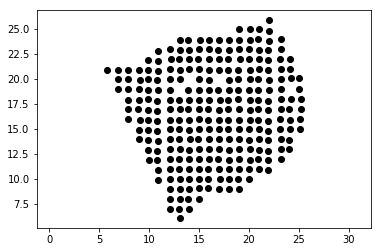

Saved: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/BreastCancer/our_results/Layer1_result_df.csv
---- rep 1 ---
scGCO: (121, 258)
spatialde: (12962, 18)
raw data dim: (251, 14789)
Rep2_processing: (248, 13495)


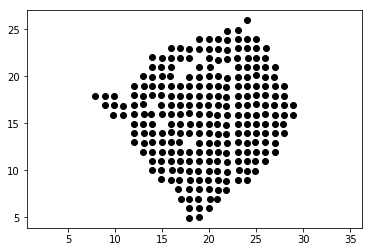

Saved: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/BreastCancer/our_results/Layer2_result_df.csv
---- rep 2 ---
scGCO: (118, 255)
spatialde: (12857, 18)
raw data dim: (264, 14929)
Rep3_processing: (261, 12744)


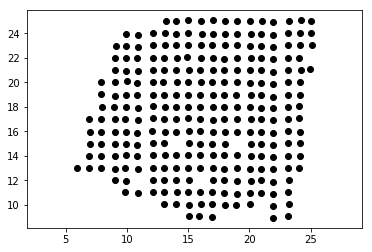

Saved: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/BreastCancer/our_results/Layer3_result_df.csv
---- rep 3 ---
scGCO: (77, 268)
spatialde: (12988, 18)
raw data dim: (262, 14808)
Rep4_processing: (259, 12692)


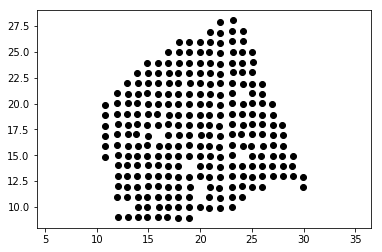

Saved: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/BreastCancer/our_results/Layer4_result_df.csv
---- rep 4 ---
scGCO: (90, 266)
spatialde: (12902, 18)


In [4]:
from general_utils import read_spatial_expression, normalize_count_cellranger
from io_utils import save_data_to_file, load_data_from_file
from main_methods import select_spatial_genes

def load_replicate_result(j, cache=True):
    # load the data for a given replicate
    ddir = '/share/PI/sabatti/sc_data/spatial_ge/scGCO'
    ff = ddir + '/data/Raw_data/MOB-breast-cancer/Layer' + str(j) +  '_BC_count_matrix-1.tsv'
    locs,data=read_spatial_expression(ff,sep='\t')
    data_norm = normalize_count_cellranger(data)
    print('Rep{}_processing: {}'.format(j,data_norm.shape))
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    ax.scatter(*locs.T, c='k')
    plt.axis('equal')
    plt.show()
    # run our method
    alpha= 0.05
    
    fn =  ddir+'/data/BreastCancer/our_results/Layer'+ str(j)+'_result_df.csv'
    if cache and os.path.exists(fn):
        result = load_data_from_file(fn, 'csv')
        rej_idx = result.loc[result['reject']].index
        print('Loaded: {}'.format(fn))
    else:
        # run our method
        pvals, rej_idx = select_spatial_genes(locs, 
                                              data_norm.values, 
                                              alpha=alpha,
                                              n_perm=100000)
        reject = np.array([False] * len(pvals))
        reject[rej_idx] = True
        result = pd.DataFrame({'pvalue': pvals, 'reject': reject, 
                               'geneID':data_norm.columns}, 
                               index=data_norm.columns)
        # save result to file
        save_data_to_file(result, fn, 'csv')        
        print('Saved: {}'.format(fn))
    ours = data_norm.columns[rej_idx]
#     pvals, rej_idx = select_spatial_genes(locs, data_norm.values, knn=8, alpha=alpha, n_perm=100000)
#     ours = data_norm.columns[rej_idx]
    # load scgco result
    print('---- rep {} ---'.format(j))
    gco = ddir + "/data/BreastCancer/scGCO_results/Layer"+str(j)+"_BC_pattern_conserved_df_exp.csv"
    counts_gco = pd.read_csv(gco,index_col=0)
    print('scGCO: {}'.format(counts_gco.shape))

    # load spatial de result
    de = ddir + "/data/BreastCancer/spatialDE_results/Layer" + str(j) + "_BC_final_results.csv"
    counts_de = pd.read_csv(de,index_col=0)
    print('spatialde: {}'.format(counts_de.shape))
    counts_de=counts_de[counts_de.qval<alpha]
    counts_de=counts_de[counts_de.g.values != 'log_total_count']

    return {
        'scGCO': set(counts_gco.index),
        'SpatialDE': set(counts_de.g.values),
        'Ours': set(ours)
    }

res = {}
for v in range(1,5):
    res[v] = load_replicate_result(v)

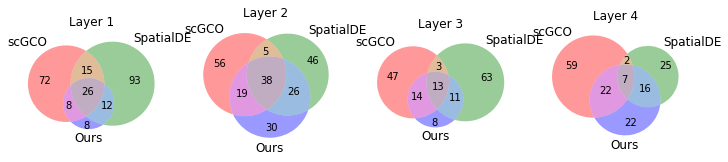

In [15]:
def plot_venn3(d, ax):
    set_labels = list(d.keys())
    subsets = [d[k] for k in set_labels]
    v=venn3(subsets=subsets, set_labels=set_labels, ax=ax)
    
    
fig, axes = plt.subplots(1, 4, figsize=(12,3))
for i, val in enumerate(res.keys()):
    ax = axes[i]
    plot_venn3(res[val], ax)
    ax.set_title('Layer {}'.format(val))
plt.show()

sceek: (15, 1)


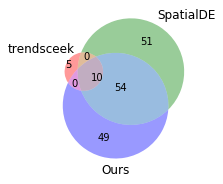

In [22]:
ex = {}
counts_sceek=pd.read_csv(ddir + "/data/BreastCancer/trendsceek_results/BC2_sig_gene_list.csv",index_col=0)
print('sceek: {}'.format(counts_sceek.shape))
ex['trendsceek'] = set(counts_sceek.sig_gene.values)
for val in ['SpatialDE', 'Ours']:
    ex[val] = res[2][val]
fig, ax = plt.subplots(1, 1, figsize=(4,3))
plot_venn3(ex, ax)
plt.show()

sceek: (15, 1)


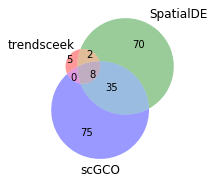

In [23]:
ex = {}
counts_sceek=pd.read_csv(ddir + "/data/BreastCancer/trendsceek_results/BC2_sig_gene_list.csv",index_col=0)
print('sceek: {}'.format(counts_sceek.shape))
ex['trendsceek'] = set(counts_sceek.sig_gene.values)
for val in ['SpatialDE', 'scGCO']:
    ex[val] = res[2][val]
fig, ax = plt.subplots(1, 1, figsize=(4,3))
plot_venn3(ex, ax)
plt.show()

# scGCO result

---- rep 1 ---
scGCO: (121, 258)
spatialde: (12962, 18)
sceek: (15, 1)
---- rep 2 ---
scGCO: (118, 255)
spatialde: (12857, 18)
sceek: (15, 1)
---- rep 3 ---
scGCO: (77, 268)
spatialde: (12988, 18)
sceek: (15, 1)
---- rep 4 ---
scGCO: (90, 266)
spatialde: (12902, 18)
sceek: (15, 1)


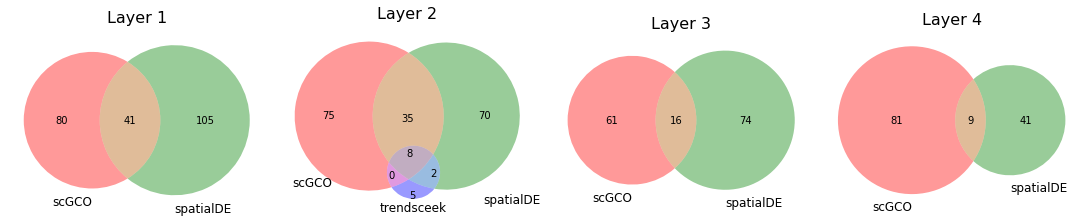

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib_venn import venn2
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
figure, axes = plt.subplots(1, 4, figsize=(15,15), constrained_layout=True)  
gco_brca_res=list()
de_brca_res=list()
sceek_brca_res=list()


for i in np.arange(4)+1:
        print('---- rep {} ---'.format(i))
        gco = ddir + "/data/BreastCancer/scGCO_results/Layer"+str(i)+"_BC_pattern_conserved_df_exp.csv"
        counts_gco = pd.read_csv(gco,index_col=0)
        print('scGCO: {}'.format(counts_gco.shape))
        gco_brca_res.append(counts_gco.shape[0])
        
        de = ddir + "/data/BreastCancer/spatialDE_results/Layer" + str(i) + "_BC_final_results.csv"
        counts_de = pd.read_csv(de,index_col=0)
        print('spatialde: {}'.format(counts_de.shape))
        counts_de=counts_de[counts_de.qval<0.05]
        counts_de=counts_de[counts_de.g.values != 'log_total_count']
        de_brca_res.append(counts_de.shape[0])
        x = int((i-1)/4)
        y= (i-1) % 4
        titleText = 'Layer ' + str(i)
        counts_sceek=pd.read_csv(ddir + "/data/BreastCancer/trendsceek_results/BC2_sig_gene_list.csv",index_col=0)
        print('sceek: {}'.format(counts_sceek.shape))
        if i !=2:
            venn2(subsets=[set(counts_gco.index.values), 
                        set(counts_de.g.values)],
                        set_labels = ('scGCO', 'spatialDE'),                     
                        ax=axes[y])
            sceek_brca_res.append(0)
        else:
            vn=venn3(subsets=[set(counts_gco.index.values), 
                           set(counts_de.g.values),
                           set(counts_sceek.sig_gene.values)],
                           set_labels = ('scGCO', 'spatialDE',"trendsceek"),                     
                           ax=axes[y])
            sceek_brca_res.append(counts_sceek.shape[0])
            lbl_A= vn.get_label_by_id("A")
            xx, yy = lbl_A.get_position()
            lbl_A.set_position((xx, yy-0.85)) 
            
            lbl_B= vn.get_label_by_id("B")
            xx, yy = lbl_B.get_position()
            lbl_B.set_position((xx, yy-0.95)) 
        ax = axes[y]
        ax.set_title(titleText, fontname="Arial", fontsize=16)
